# Experiment

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case

1. Linear-shift DGP and linear-shift model  
2. **Complex-shift DGP and complex-shift model**  <------------------
3. Linear-shift DGP and complex-shift model 


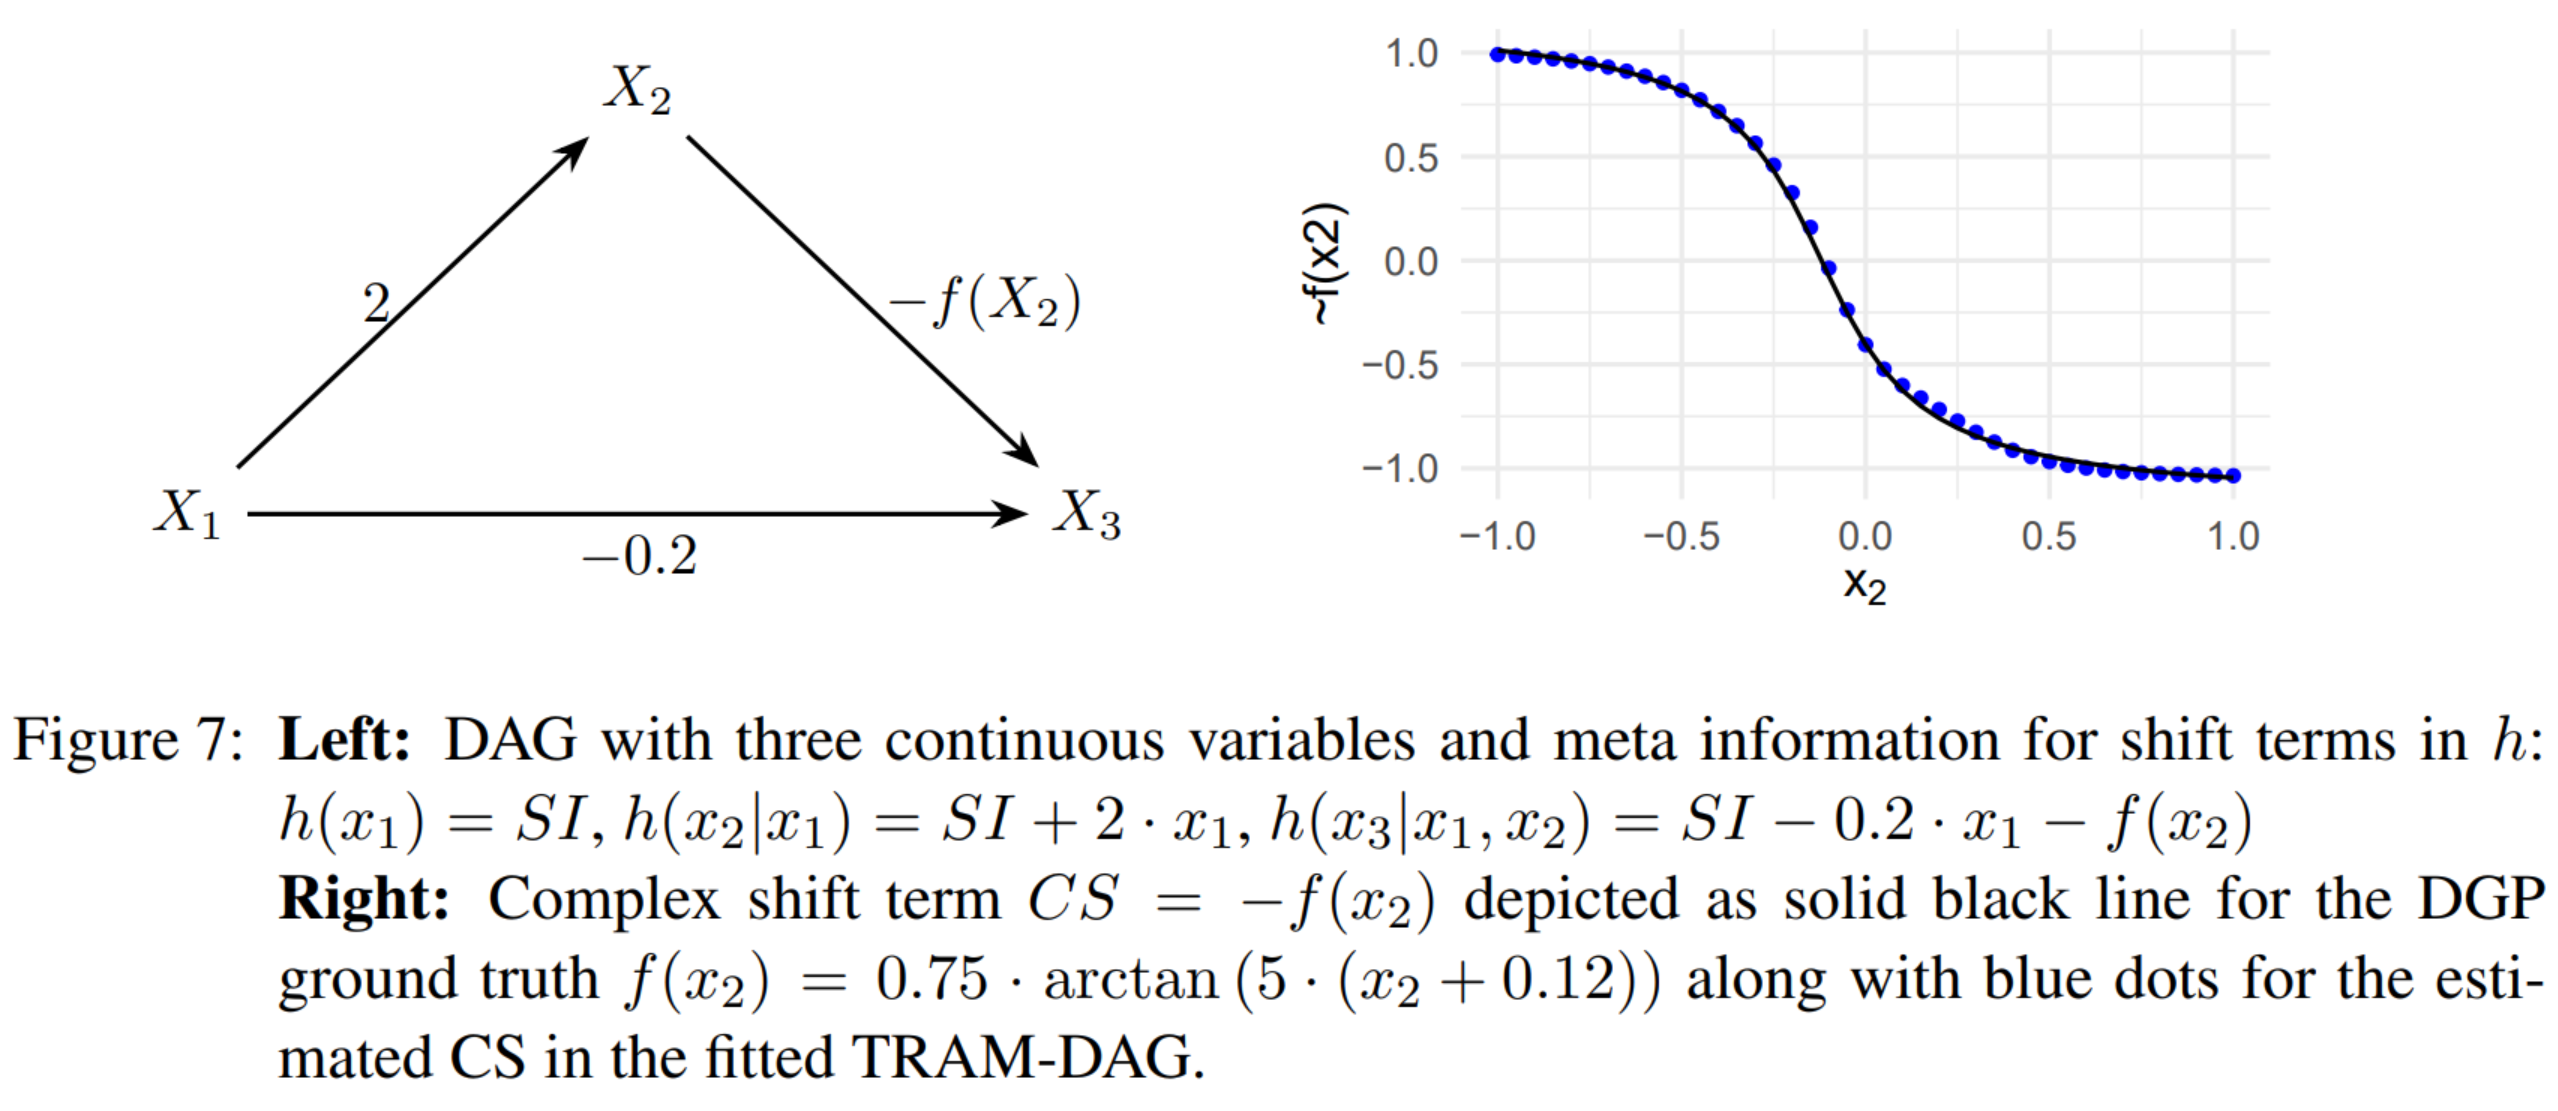




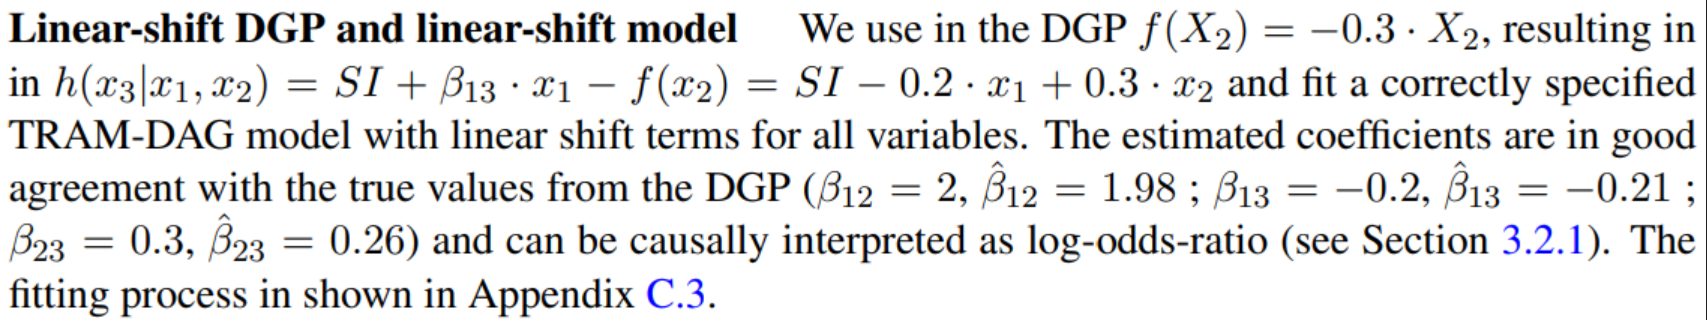

## DATA

Setting Seed: 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB
Train size: 80000, Validation size: 10000, Test size: 10000


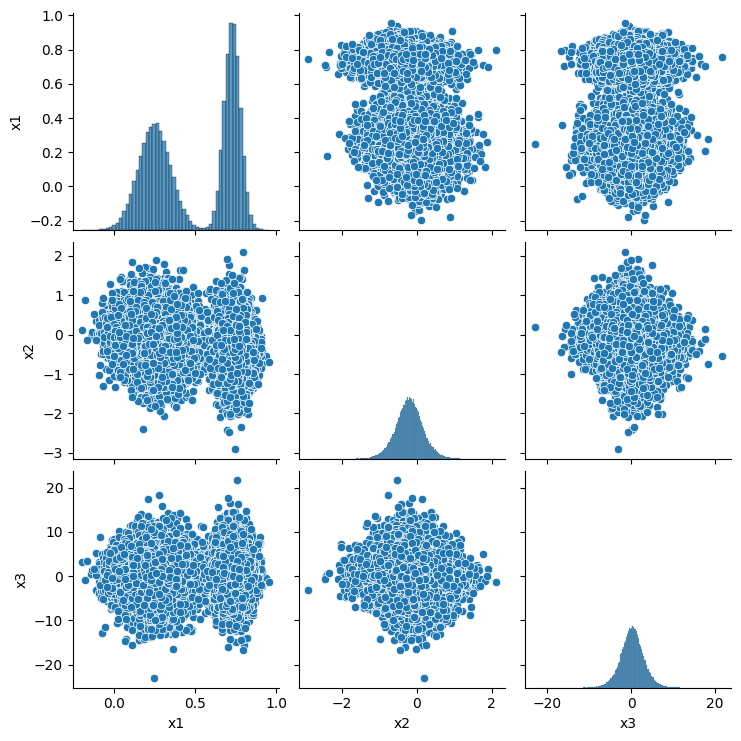

In [1]:
from scipy.special import logit
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns


# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return -0.3*x  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])
        
    #df = pd.DataFrame({'x1': x1, 'x2': x2})#, 'x3': x3})
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

df = dgp(n_obs=100_000, seed=42)
df.info()
sns.pairplot(df)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

In [2]:
from tramdag import TramDagConfig
import os

In [3]:
experiment_name = "Continous_3_vars_linear_DGP_CS"      ## <--- set experiment name
EXPERIMENT_DIR = os.path.join(os.getcwd(), experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")
cfg=TramDagConfig()
cfg.setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists: /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/configuration.json


In [4]:
data_type= {'x1':'continous','x2':'continous','x3':'continous'} 
cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/configuration.json.


/home/bule/anaconda3/envs/tramdag_test/lib/python3.9/site-packages/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


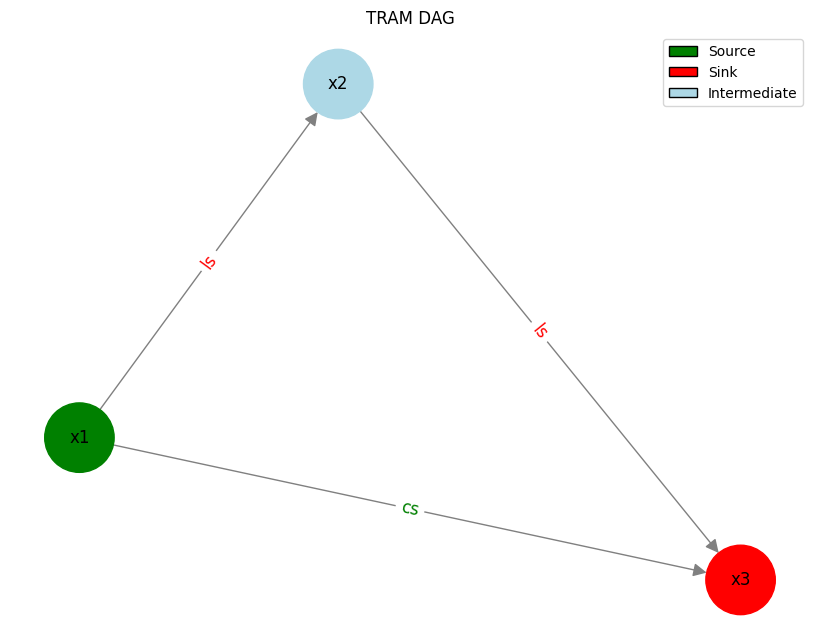

In [5]:
cfg.set_meta_adj_matrix()

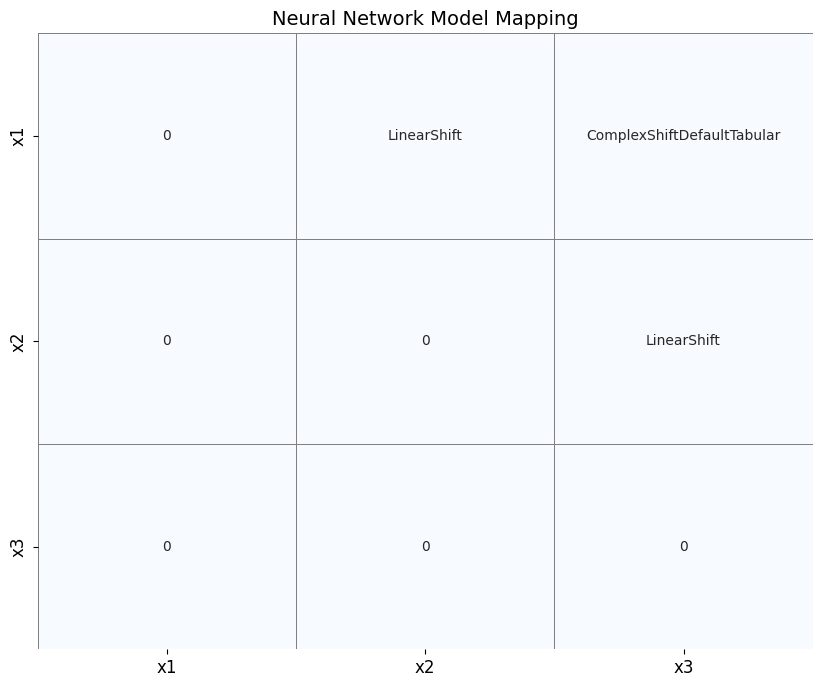

In [6]:
cfg.set_tramdag_nn_models()

# Fit

In [7]:
from tramdag import TramDagModel
device='cpu'

In [8]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=True,verbose=True,debug=False,device=device,initial_data = train_df) 

[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)


In [9]:
EPOCHS=400 
BATCH_SIZE=1000


td_model.fit(train_df, val_df,
             learning_rate=1e-2,
             train_list=["x3"],
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             device=device,
             num_workers=8,
             prefetch_factor=8,
             persistent_workers =True)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/min_max_scaling.json
[INFO] Training 1 nodes (sequential) on cpu

[INFO] Training node 'x3' for 400 epochs on cpu (pid=3068939)
[INFO] Existing model found. Loading weights and history from LAST model...

===== Epoch 301/400 =====
[INFO] Saved linear shift weights for epoch 301 -> /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x3/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 301 -> /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x3/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 301: Train NLL=2.4185 | Val NLL=2.4176 | Time=1.90s

===== Epoch 302/400 =====
[INFO] Saved linear shift weights for epoch 302 -> /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x3/linear_shifts_all_epochs.json
[INFO] Saved simple intercept

# Fit diagnostics

[INFO] Loaded training/validation histories for 3 nodes.


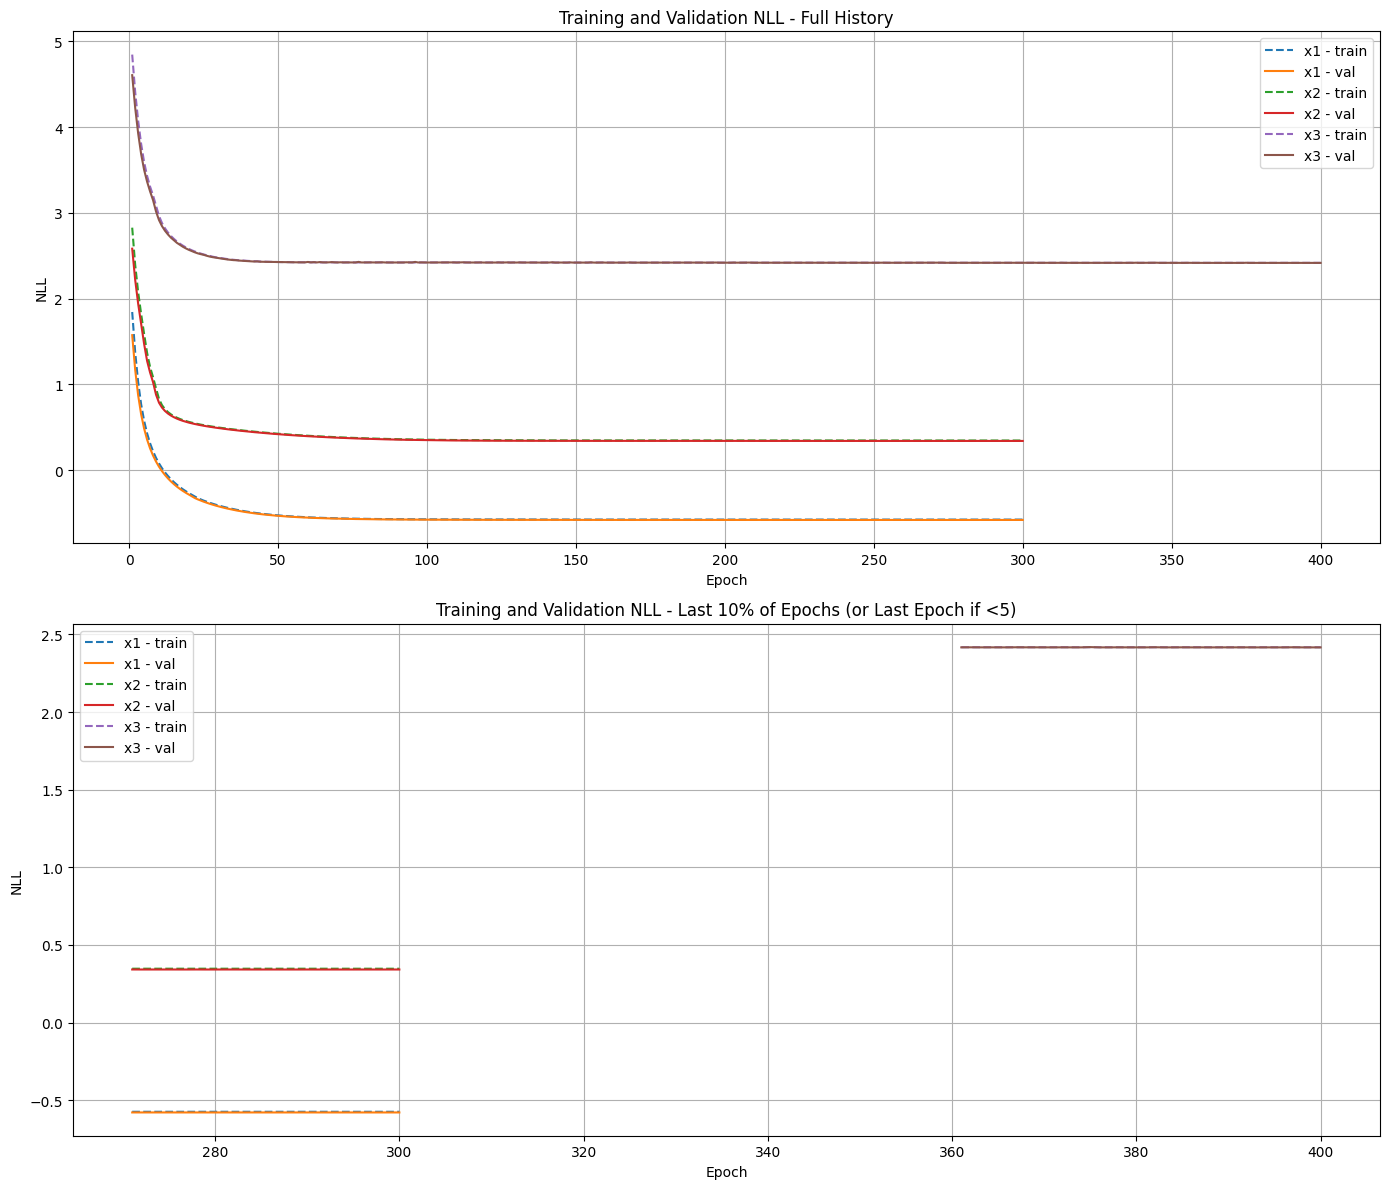

In [10]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x1/linear_shifts_all_epochs.json


/home/bule/anaconda3/envs/tramdag_test/lib/python3.9/site-packages/tramdag/TramDagModel.py:936: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(flatten)


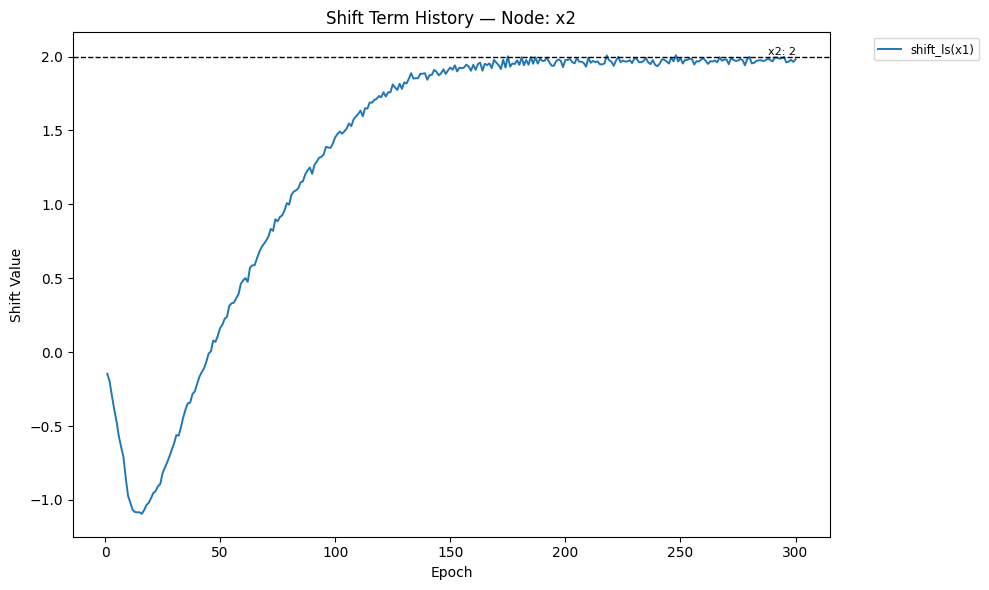

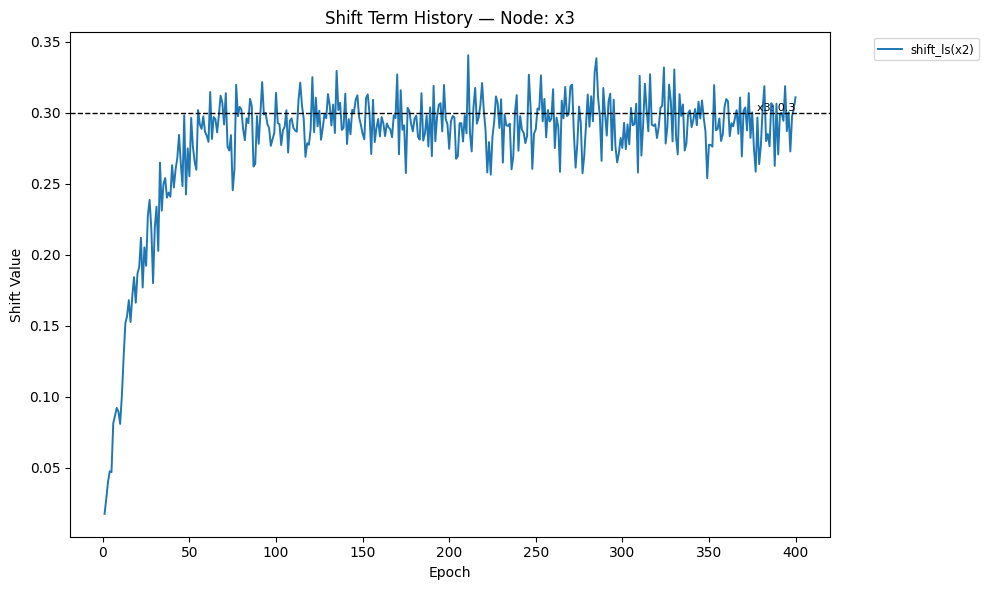

In [11]:
td_model.plot_linear_shift_history(ref_lines={'x2':[2],'x3':[0.3]}) 

/home/bule/anaconda3/envs/tramdag_test/lib/python3.9/site-packages/tramdag/TramDagModel.py:989: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


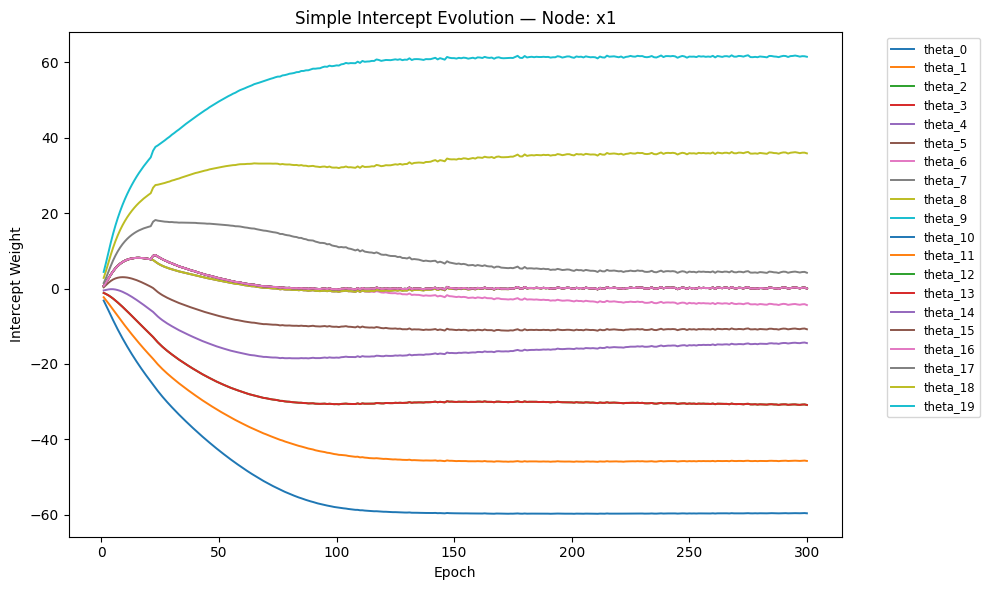

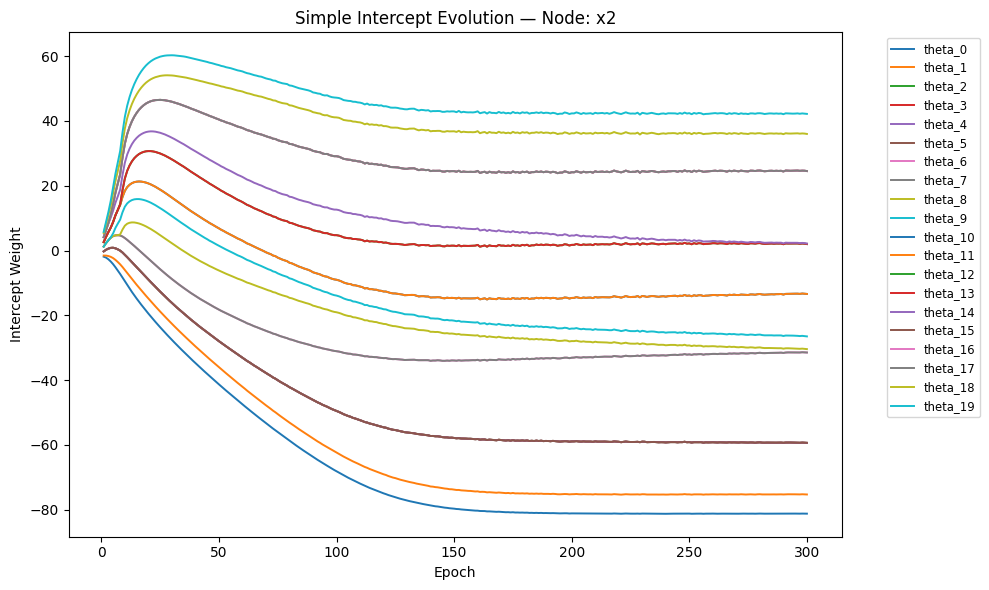

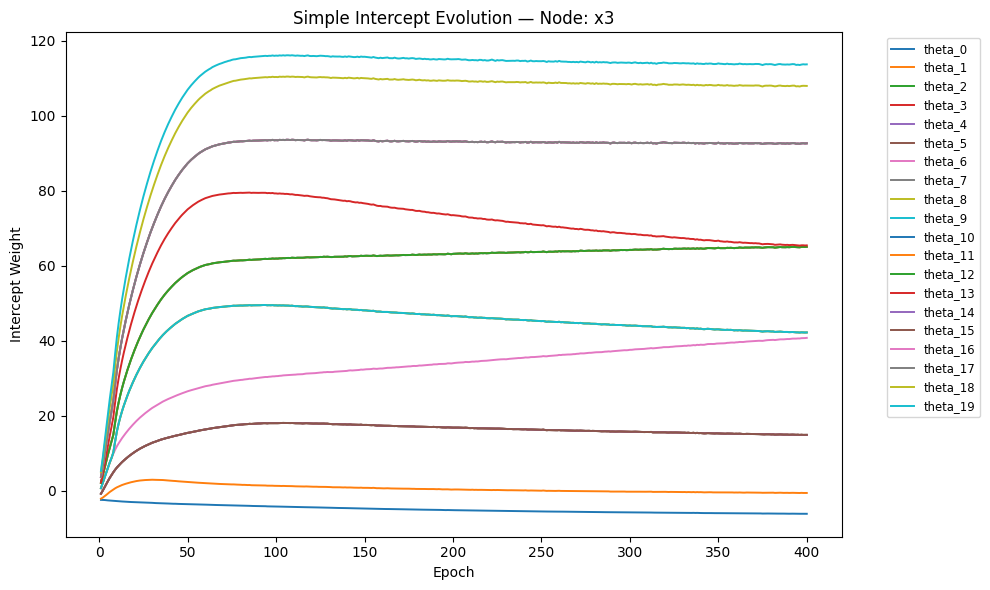

In [12]:
td_model.plot_simple_intercepts_history()

[WARNING] len(df)>1, set: plot_n_rows accordingly
x1: Simple intercept — identical h() for all samples.


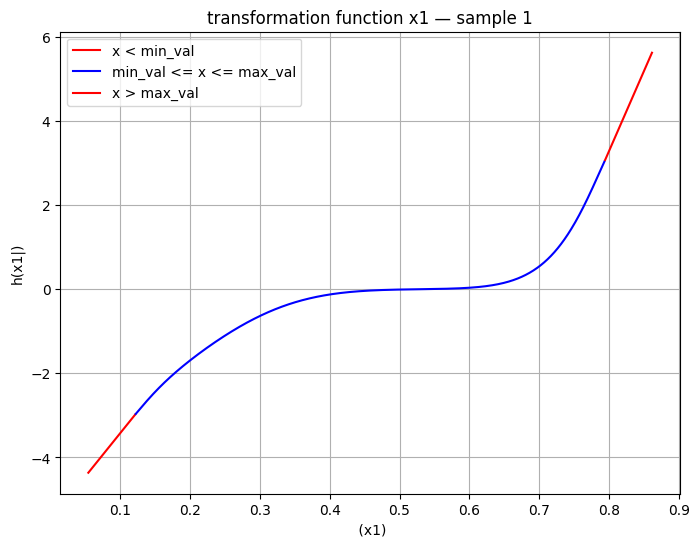


=== Sample 1/1 ===
x1    0.729475
x2   -0.573516
x3   -4.138028
Name: 75220, dtype: float64


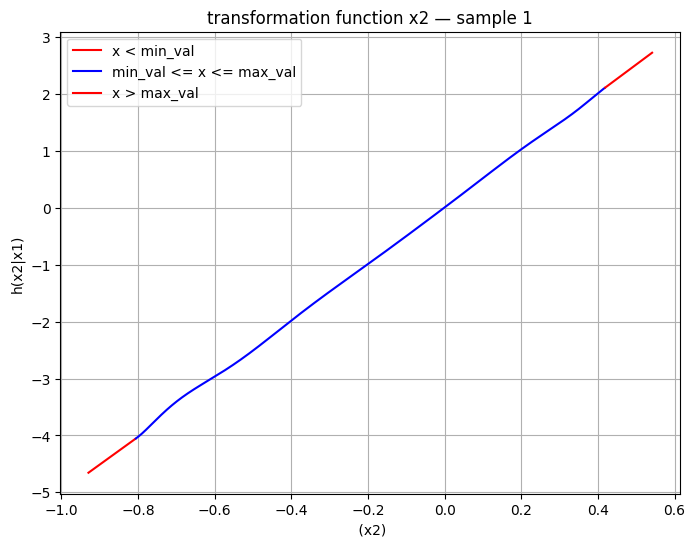


=== Sample 1/1 ===
x1    0.729475
x2   -0.573516
x3   -4.138028
Name: 75220, dtype: float64


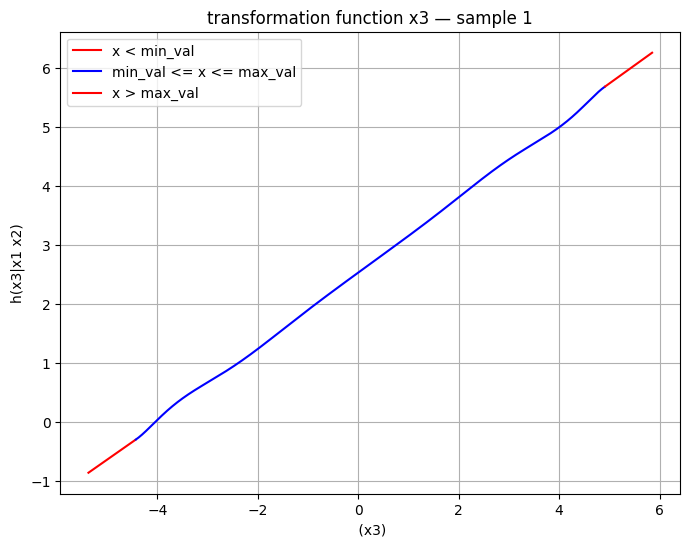

In [13]:
td_model.plot_hdag(train_df,variables=['x1','x2','x3'],plot_n_rows=1)

[INFO] Final latent DataFrame shape: (80000, 6)


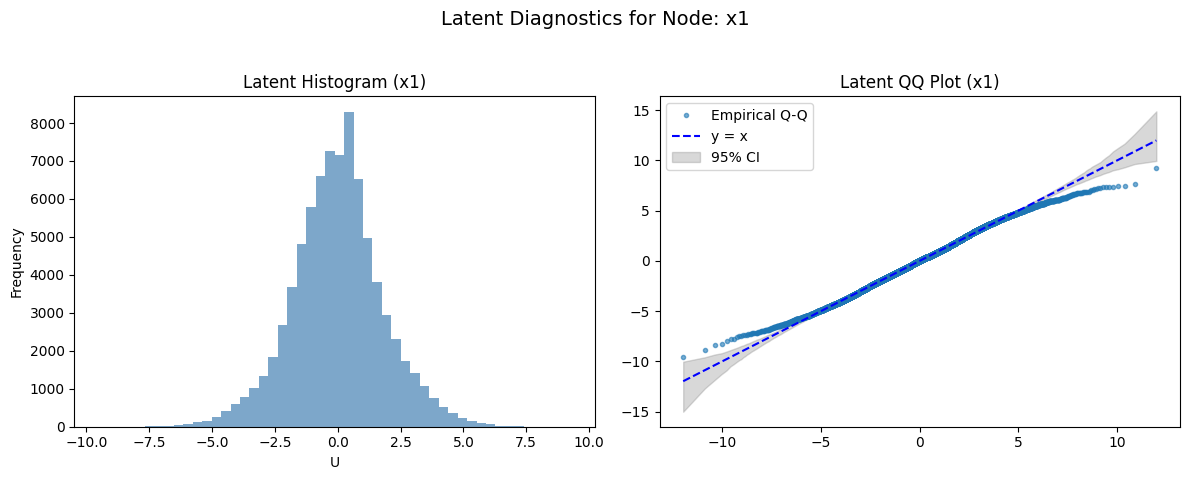

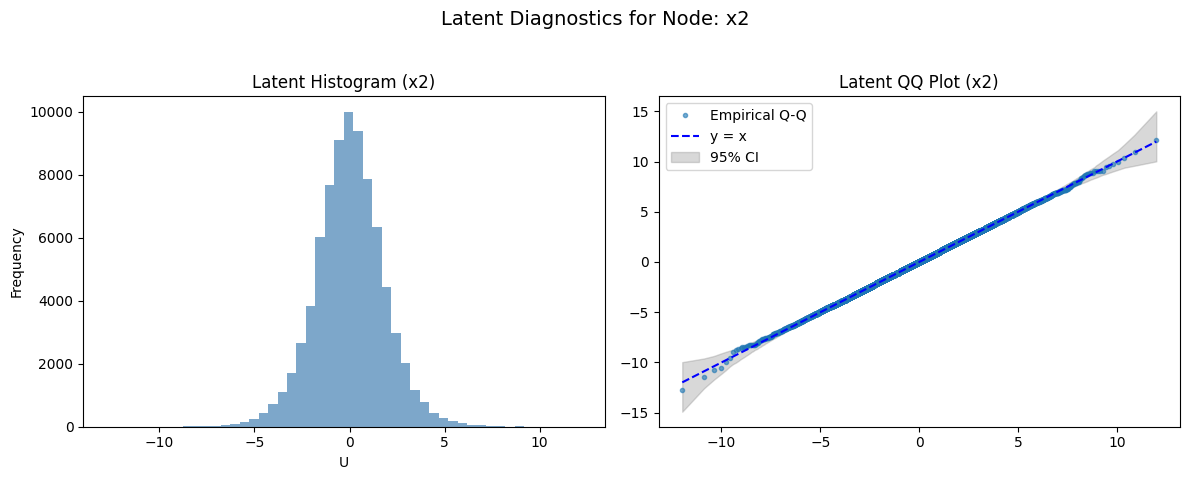

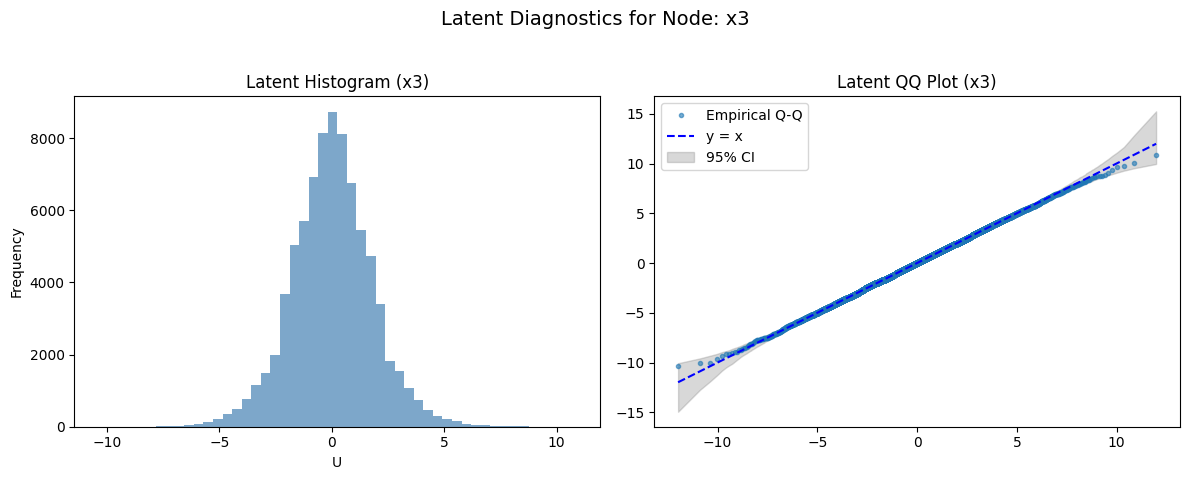

In [14]:
td_model.plot_latents(train_df)

In [15]:
td_model.nll(train_df)

{'x1': 2.118129094441732, 'x2': 3.0700948238372803, 'x3': 2.416849454243978}

/tmp/ipykernel_3068939/3589819528.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")


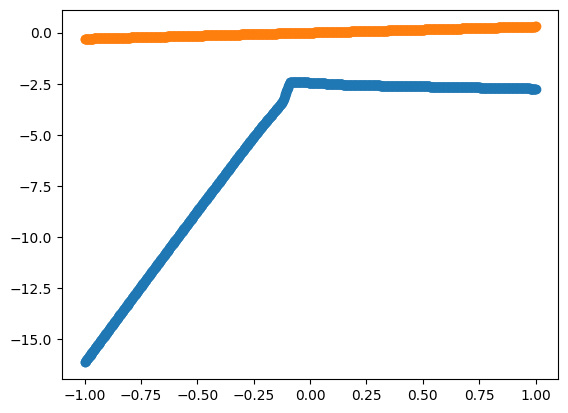

In [16]:
import torch
import matplotlib.pyplot as plt

x = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (100, 1)

with torch.no_grad():
    y=td_model.models['x3'].nn_shift[0](x) # take node x3 nnshift list and the first element which is the complex shift
plt.scatter(x.cpu().numpy(),y.cpu().numpy())
plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")
plt.show()

# SAMPLING

## Observational

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x1/sampling
Directory does not exist: /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x2/sampling
Directory does not exist: /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.32it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 48.36it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 50.62it/s]


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


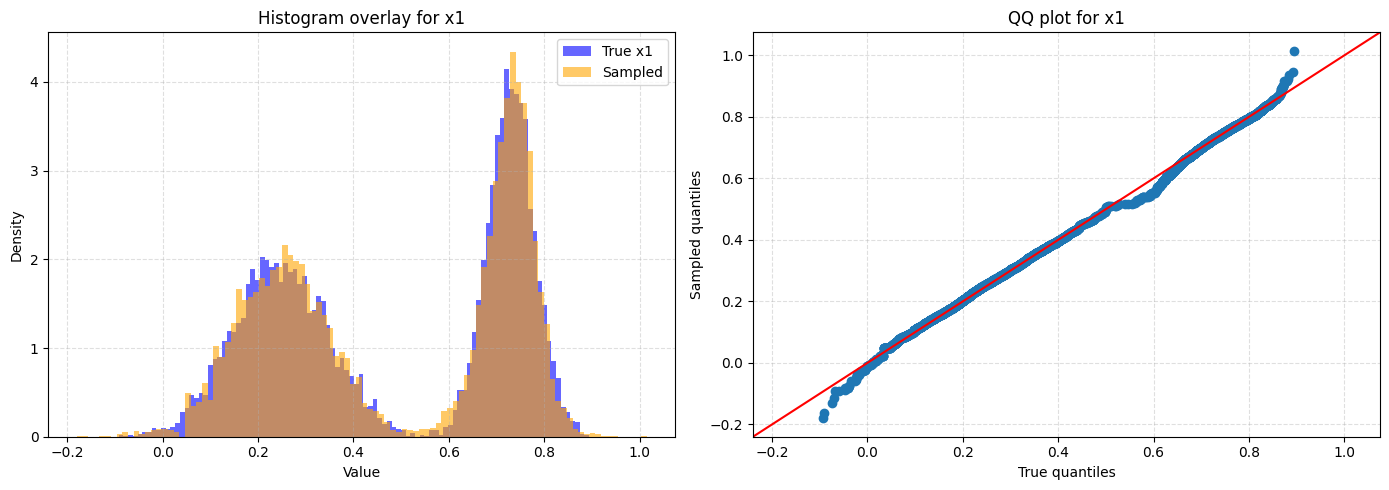

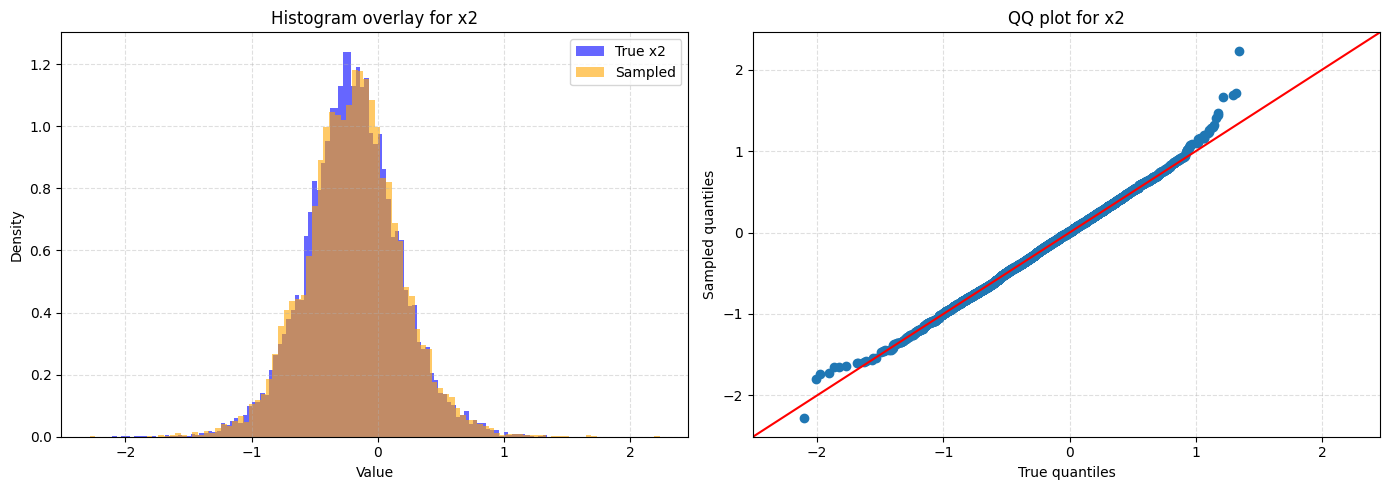

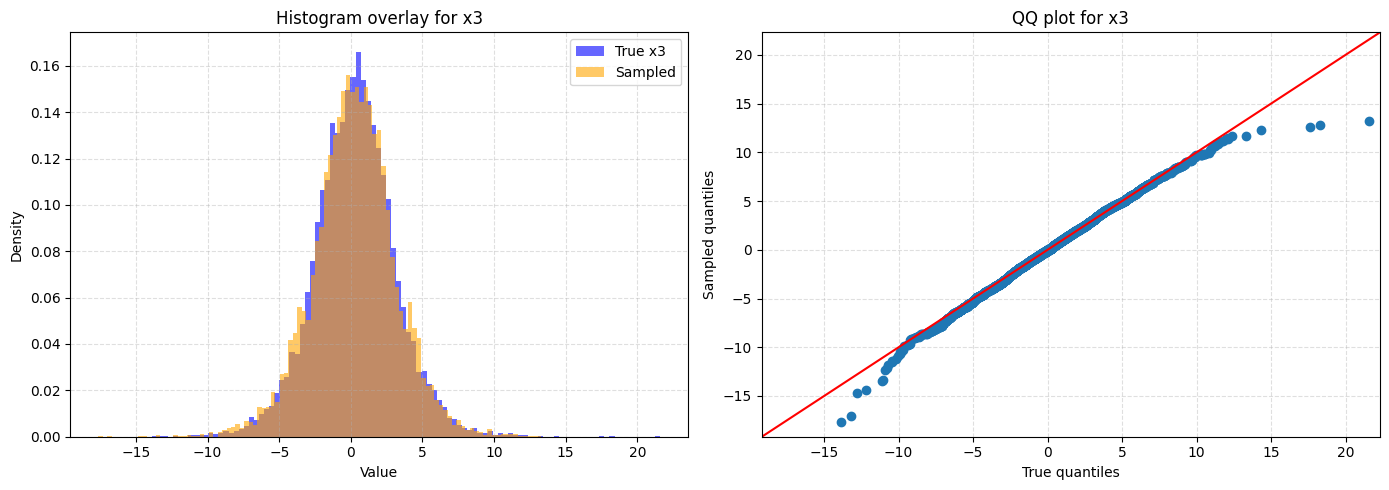

In [17]:
samples_observational, latents = td_model.sample()
td_model.plot_samples_vs_true(test_df,samples_observational)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['x1']
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x1/sampling
Deleted directory: /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x2/sampling
Deleted directory: /home/bule/TramDag/example_notebooks/Continous_3_vars_linear_DGP_CS/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'x1' with value 0.0
[INFO] Interventional data for node x1 is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 48.62it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 48.71it/s]


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


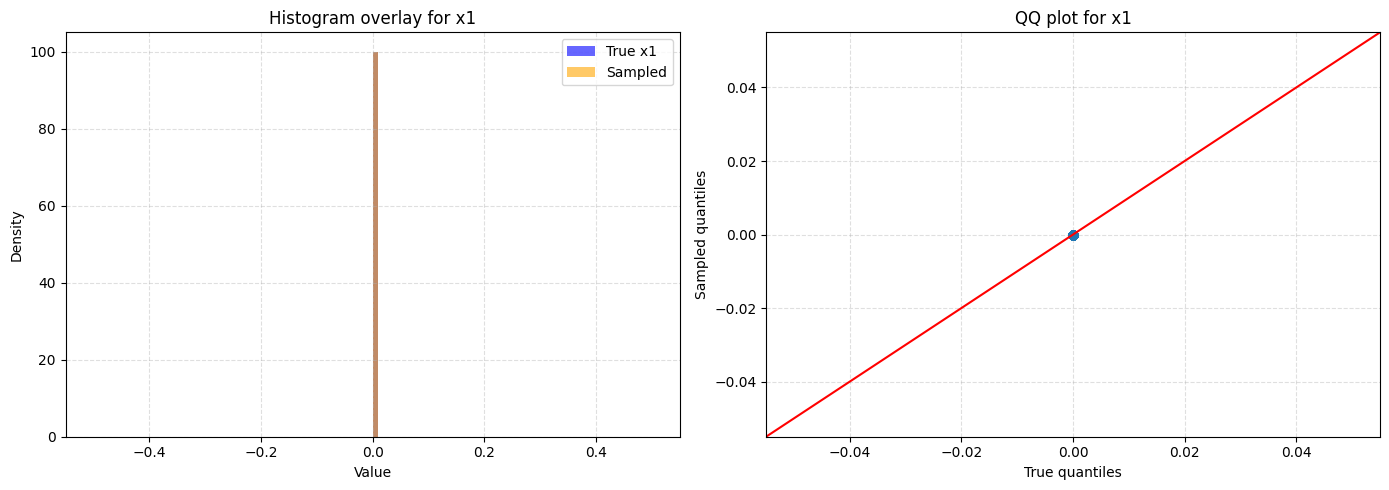

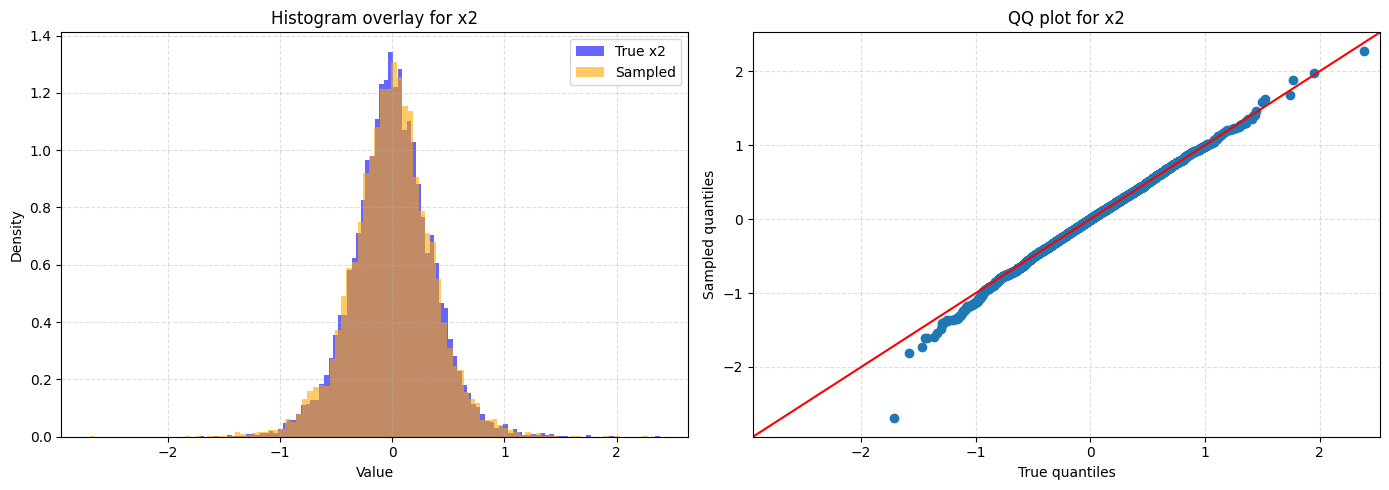

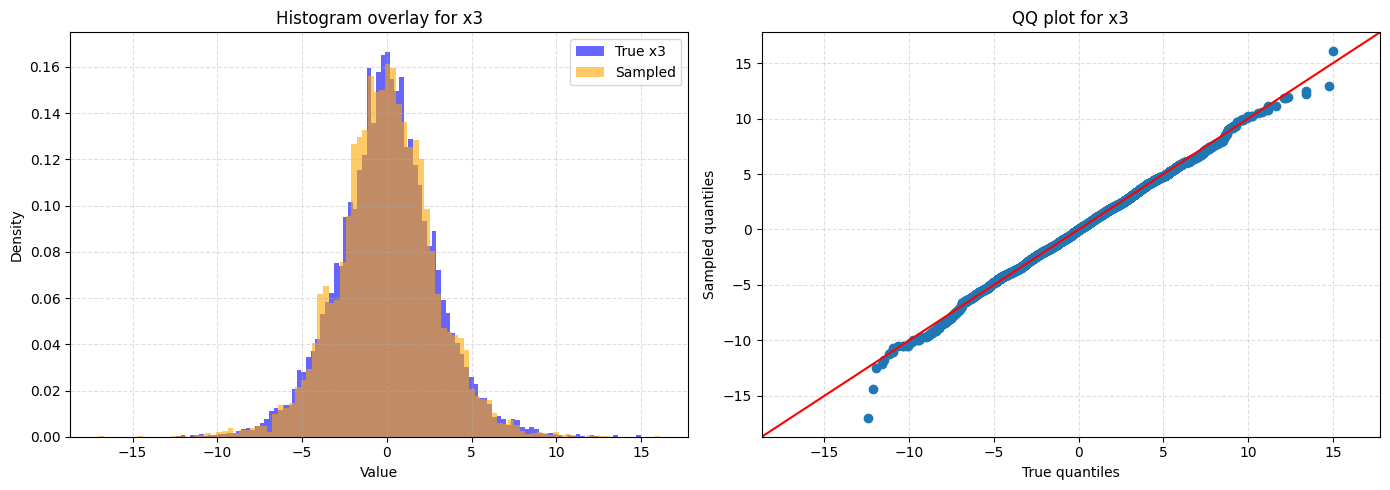

In [18]:
intervention_value= 0.0
samples_inter, latents = td_model.sample(do_interventions={'x1':intervention_value})
inter_df=dgp(n_obs=10_000, doX=[intervention_value , None, None])
td_model.plot_samples_vs_true(inter_df,samples_inter)
